In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.colors import Normalize
from scipy import fftpack
from scipy.sparse import csr_matrix
import scipy.sparse
# Importing fft functions from scipy
from scipy.fft import fft, fftfreq, fftshift

In [1]:
# matplotlib parameters 
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)

folder_name_dict = { 'run_0': 0.0,
                    'run_1': 0.1,
                    'run_2': 0.2,
                    'run_3': 0.3,
                    'run_4': 0.4,
                    'run_5': 0.5,
                    'run_6': 0.6,
                    'run_7': 0.7,
                    'run_8': 0.8,
                    'run_9': 0.9,
                    'run_10': 1.0}   

folder_name_lst = [keys for keys in folder_name_dict.keys()]
folder_name = folder_name_lst[0]
print("Folder name: ", folder_name)
total_number_of_b_folders = 128
b_index = total_number_of_b_folders - 1
path = '/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/' + str(folder_name) + '/b' + str(b_index)
os.chdir(path)
number_of_atoms = 10 * 1.e3
print("Number of atoms: ", number_of_atoms)
a_s_factor = np.load("a_s_factor.npy") 
print("a_s = ", a_s_factor/0.01)
V_SG = 30 # kHz
V_GD = 33 # kHz
print("V_SG = ", V_SG, "kHz")
print("V_GD = ", V_GD, "kHz")

NameError: name 'plt' is not defined

In [3]:
b_start = 0
b_end = total_number_of_b_folders - 1
b_index = b_start
path = '/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/' + str(folder_name) + '/b' + str(b_index)
os.chdir(path)
V_SS_start_factor = np.load("source_bias.npy")
print("V_SS_start_factor = ", V_SS_start_factor)
b_index = b_end
path = '/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/' + str(folder_name) + '/b' + str(b_index)
os.chdir(path)
V_SS_end_factor = np.load("source_bias.npy")
print("V_SS_end_factor = ", V_SS_end_factor)
V_SS_lst_to_plot = np.linspace(V_SS_start_factor, V_SS_end_factor, total_number_of_b_folders)

V_SS_start_factor =  23.0
V_SS_end_factor =  30.0


In [4]:
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)
ATOM_MASS = 1.4192261*10**(-25) # kg
barrier_height_SG = V_SG # kHz
barrier_height_GD = V_GD # kHz
os.chdir(path)
gate_well_start = 0.0
gate_well_end = 4.8
print("Gate well width = ", gate_well_end - gate_well_start,r"$\mu m$")

single_particle_omega = np.sqrt(8*barrier_height_SG*10**3*H_BAR*2*PI/(ATOM_MASS*(gate_well_end*1.e-6 - gate_well_start*1.e-6)**2))
print(r"Single particle energy level frequency = ", single_particle_omega, "(rad/s)")
n_levels = int((barrier_height_SG*10**3*H_BAR*2*PI)/(H_BAR*7415) - 1/2)
print("Number of single particle energy levels in the gate well = ", n_levels)

single_particle_omega = 2*np.pi*1178
print("Time period = ", 2*np.pi/single_particle_omega * 1.e3, "s")

Gate well width =  4.8 $\mu m$
Single particle energy level frequency =  6973.716763152236 (rad/s)
Number of single particle energy levels in the gate well =  24
Time period =  0.8488964346349746 s


# New code

In [77]:
import os
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# Parameters
time_step = 1e-6  # seconds
tinit = 0.0e-3
tmax = 300e-3  # seconds

def gaussian(x, amplitude, center, width):
    """Gaussian function for curve fitting"""
    return amplitude * np.exp(-(x - center)**2 / (2 * width**2))

# Full time array from 0 to tmax
full_time_lst = np.arange(0.0, tmax, time_step)
start_idx = int(tinit / time_step)
end_idx = int(tmax / time_step)
print(f"Cropping from index {start_idx} to {end_idx} (time {tinit}s to {tmax}s)")

# Frequency range around target omega
omega_lower_limit = single_particle_omega - single_particle_omega / 3
omega_upper_limit = single_particle_omega + single_particle_omega / 3
b_index_lst = list(range(total_number_of_b_folders))

# smoothing_type = 'both'  # Options: 'gaussian', 'savgol', 'median', 'none', 'both'
# smoothing_type = 'gaussian'  # Options: 'gaussian', 'savgol', 'median', 'none', 'both'
smoothing_type = 'savgol'

for folder_name in folder_name_lst:
    print("Folder name: ", folder_name)
    peak_heights_drain = []
    peak_areas_drain = []
    b_with_valid_peaks = []

    for b_index in b_index_lst:
        print("b_index: ", b_index)
        path = f'/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/{folder_name}/b{b_index}'
        os.chdir(path)

        wavefunction = np.load("wavefunction_at_40um_vs_time_bias_idx_" + str(b_index) + ".npy")[:,1]
        density_drain = np.abs(wavefunction) ** 2

        density_drain = density_drain - np.mean(density_drain)

        density_drain = density_drain[start_idx:end_idx]
        print("Density shape after cropping:", density_drain.shape)

        # Apply FFT and smoothing as before
        N = len(density_drain)
        fft_values = fft(density_drain)
        frequencies = fftfreq(N, d=time_step)
        power_spectrum = np.abs(fft_values) ** 2
        frequencies_shifted = fftshift(frequencies)
        power_spectrum_shifted = fftshift(power_spectrum)

        # Apply smoothing (keeping existing smoothing code)
        if smoothing_type == 'savgol':
            window = 131 if N > 131 else N | 1
            power_spectrum_smooth = savgol_filter(power_spectrum_shifted, 
                                                window_length = window, 
                                                polyorder = 2)

        # Scale power spectrum for better numerical handling
        power_spectrum_smooth = power_spectrum_smooth * 1e9
        scale_factor = 1e9

        freqs_rad = 2 * np.pi * frequencies_shifted
        
        # Find indices for the three points
        freq_mask = (freqs_rad > omega_lower_limit) & (freqs_rad < omega_upper_limit)
        power_in_range = power_spectrum_smooth[freq_mask]
        freq_in_range = freqs_rad[freq_mask]
        
        if len(power_in_range) > 0:
            peak_idx = np.argmax(power_in_range)
            peak_freq = freq_in_range[peak_idx]
            
            # Calculate symmetric points around peak
            left_freq = peak_freq - single_particle_omega / 3
            right_freq = peak_freq + single_particle_omega / 3

            # Find indices closest to these frequencies
            left_idx = np.argmin(np.abs(freqs_rad - left_freq))
            right_idx = np.argmin(np.abs(freqs_rad - right_freq))

            # Get the exact frequencies and power values at these three points
            freq_range = np.array([freqs_rad[left_idx], peak_freq, freqs_rad[right_idx]])
            power_range = np.array([power_spectrum_smooth[left_idx],
                                  power_in_range[peak_idx], 
                                  power_spectrum_smooth[right_idx]])

            try:
                # Calculate peak significance
                peak_height = power_range[1]  # Middle point (peak)
                background = min(power_range[0], power_range[2])  # Min of symmetric points
                peak_significance = peak_height / background if background > 0 else 0
                
                # Initial parameter guesses
                p0 = [power_range[1], peak_freq, single_particle_omega/20]
                bounds = ([0, omega_lower_limit, 0],
                          [np.inf, omega_upper_limit, single_particle_omega/5])

                if power_range[1] > max(power_range[0], power_range[2]) and peak_significance > 1.5:
                    popt, pcov = curve_fit(gaussian, freq_range, power_range, p0=p0, bounds=bounds)
                    peak_height = popt[0] / scale_factor  # Scale back to original units
                    peak_area = peak_height * popt[2] * np.sqrt(2 * np.pi)
                    b_with_valid_peaks.append(b_index)
                else:
                    peak_height = 0.0
                    peak_area = 0.0
                    
            except RuntimeError as e:
                print(f"Fit failed at b_index {b_index}: {str(e)}")
                peak_height = 0.0
                peak_area = 0.0

        peak_heights_drain.append(peak_height)
        peak_areas_drain.append(peak_area)

    save_path = '/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/Figures/'
    os.makedirs(save_path, exist_ok=True)
    os.chdir(save_path)
    np.save(f"{folder_name}_peak_FFT_heights_drain_signal_{int(omega_lower_limit)}_{int(omega_upper_limit)}.npy",
            np.array(peak_heights_drain))
    np.save(f"{folder_name}_peak_FFT_areas_of_FFT_drain_signal_{int(omega_lower_limit)}_{int(omega_upper_limit)}.npy",
            np.array(peak_areas_drain))
    np.save(f"{folder_name}_b_with_peak_FFT_signal_{int(omega_lower_limit)}_{int(omega_upper_limit)}.npy",
            np.array(b_with_valid_peaks))

Cropping from index 0 to 300000 (time 0.0s to 0.3s)
Folder name:  run_0
b_index:  0
Density shape after cropping: (299999,)
b_index:  1
Density shape after cropping: (299999,)
b_index:  2
Density shape after cropping: (299999,)
b_index:  3
Density shape after cropping: (299999,)
b_index:  4
Density shape after cropping: (299999,)
b_index:  5
Density shape after cropping: (299999,)
b_index:  6
Density shape after cropping: (299999,)
b_index:  7
Density shape after cropping: (299999,)
b_index:  8
Density shape after cropping: (299999,)
b_index:  9
Density shape after cropping: (299999,)
b_index:  10
Density shape after cropping: (299999,)
b_index:  11
Density shape after cropping: (299999,)
b_index:  12
Density shape after cropping: (299999,)
b_index:  13
Density shape after cropping: (299999,)
b_index:  14
Density shape after cropping: (299999,)
b_index:  15
Density shape after cropping: (299999,)
b_index:  16
Density shape after cropping: (299999,)
b_index:  17
Density shape after crop

/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_23612/4101451161.py:107: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, freq_range, power_range, p0=p0, bounds=bounds)


b_index:  38
Density shape after cropping: (299999,)
b_index:  39
Density shape after cropping: (299999,)
b_index:  40
Density shape after cropping: (299999,)
b_index:  41
Density shape after cropping: (299999,)
b_index:  42
Density shape after cropping: (299999,)
b_index:  43
Density shape after cropping: (299999,)
b_index:  44
Density shape after cropping: (299999,)
b_index:  45
Density shape after cropping: (299999,)
b_index:  46
Density shape after cropping: (299999,)
b_index:  47
Density shape after cropping: (299999,)
b_index:  48
Density shape after cropping: (299999,)
b_index:  49
Density shape after cropping: (299999,)
b_index:  50
Density shape after cropping: (299999,)
b_index:  51
Density shape after cropping: (299999,)
b_index:  52
Density shape after cropping: (299999,)
b_index:  53
Density shape after cropping: (299999,)
b_index:  54
Density shape after cropping: (299999,)
b_index:  55
Density shape after cropping: (299999,)
b_index:  56
Density shape after cropping: (29

In [78]:
path = '/Volumes/SASANKA_SSD/atomtronics_backup/atomtronics_modular_data/Figures/'
os.chdir(path)

# 127
source_bias_lst = [ np.linspace(23, 30, 128),       # 0.0
                    np.linspace(21, 28, 128),       # 0.1     
                    np.linspace(19, 26, 128),       # 0.2
                    np.linspace(17, 24, 128),       # 0.3
                    np.linspace(14, 21, 128),       # 0.4
                    np.linspace(11, 19, 128),       # 0.5
                    np.linspace(8,  16, 128),       # 0.6
                    np.linspace(5,  13, 128),       # 0.7
                    np.linspace(4,  12, 128),       # 0.8
                    np.linspace(1,  9, 128),        # 0.9
                    np.linspace(1,  9, 128),        # 1.0
                    ]

chemical_potential_V_SS_value_lst = np.array([ 30.0,    # 0.0
                                               27.20,   # 0.1
                                               24.57,   # 0.2
                                               21.98,   # 0.3
                                               19.90,   # 0.4
                                               17.70,   # 0.5
                                               15.75,   # 0.6
                                               13.00,   # 0.7
                                               11.75,   # 0.8
                                               9,       # 0.9
                                               7.93     # 1.0
                                              ])

folder_name_lst = list(folder_name_dict.keys())
a_s_lst = list(folder_name_dict.values())

Rb87_as = 5.29e-9 # in m

a_s_SI = np.array(a_s_lst)*(98.006*5.29*10**(-11)) * 1.e10

drain_peak_height_lst = []
#drain_peak_area_lst = []

for a_s_value, folder_name in zip(a_s_lst, folder_name_lst):
     
     print("Folder name: ", folder_name)

     drain_peak = np.load(str(folder_name)+'_peak_FFT_heights_drain_signal_'+str(int(omega_lower_limit)) +'_'+str(int(omega_upper_limit))+'.npy')
     #drain_peak_area = np.load(str(folder_name)+'_peak_FFT_areas_of_FFT_drain_signal_'+str(int(omega_lower_limit)) +'_'+str(int(omega_upper_limit))+'.npy')

     drain_peak_height_lst.append(drain_peak)
     #drain_peak_area_lst.append(drain_peak_area)

Folder name:  run_0
Folder name:  run_1
Folder name:  run_2
Folder name:  run_3
Folder name:  run_4
Folder name:  run_5
Folder name:  run_6
Folder name:  run_7
Folder name:  run_8
Folder name:  run_9
Folder name:  run_10


# Plot

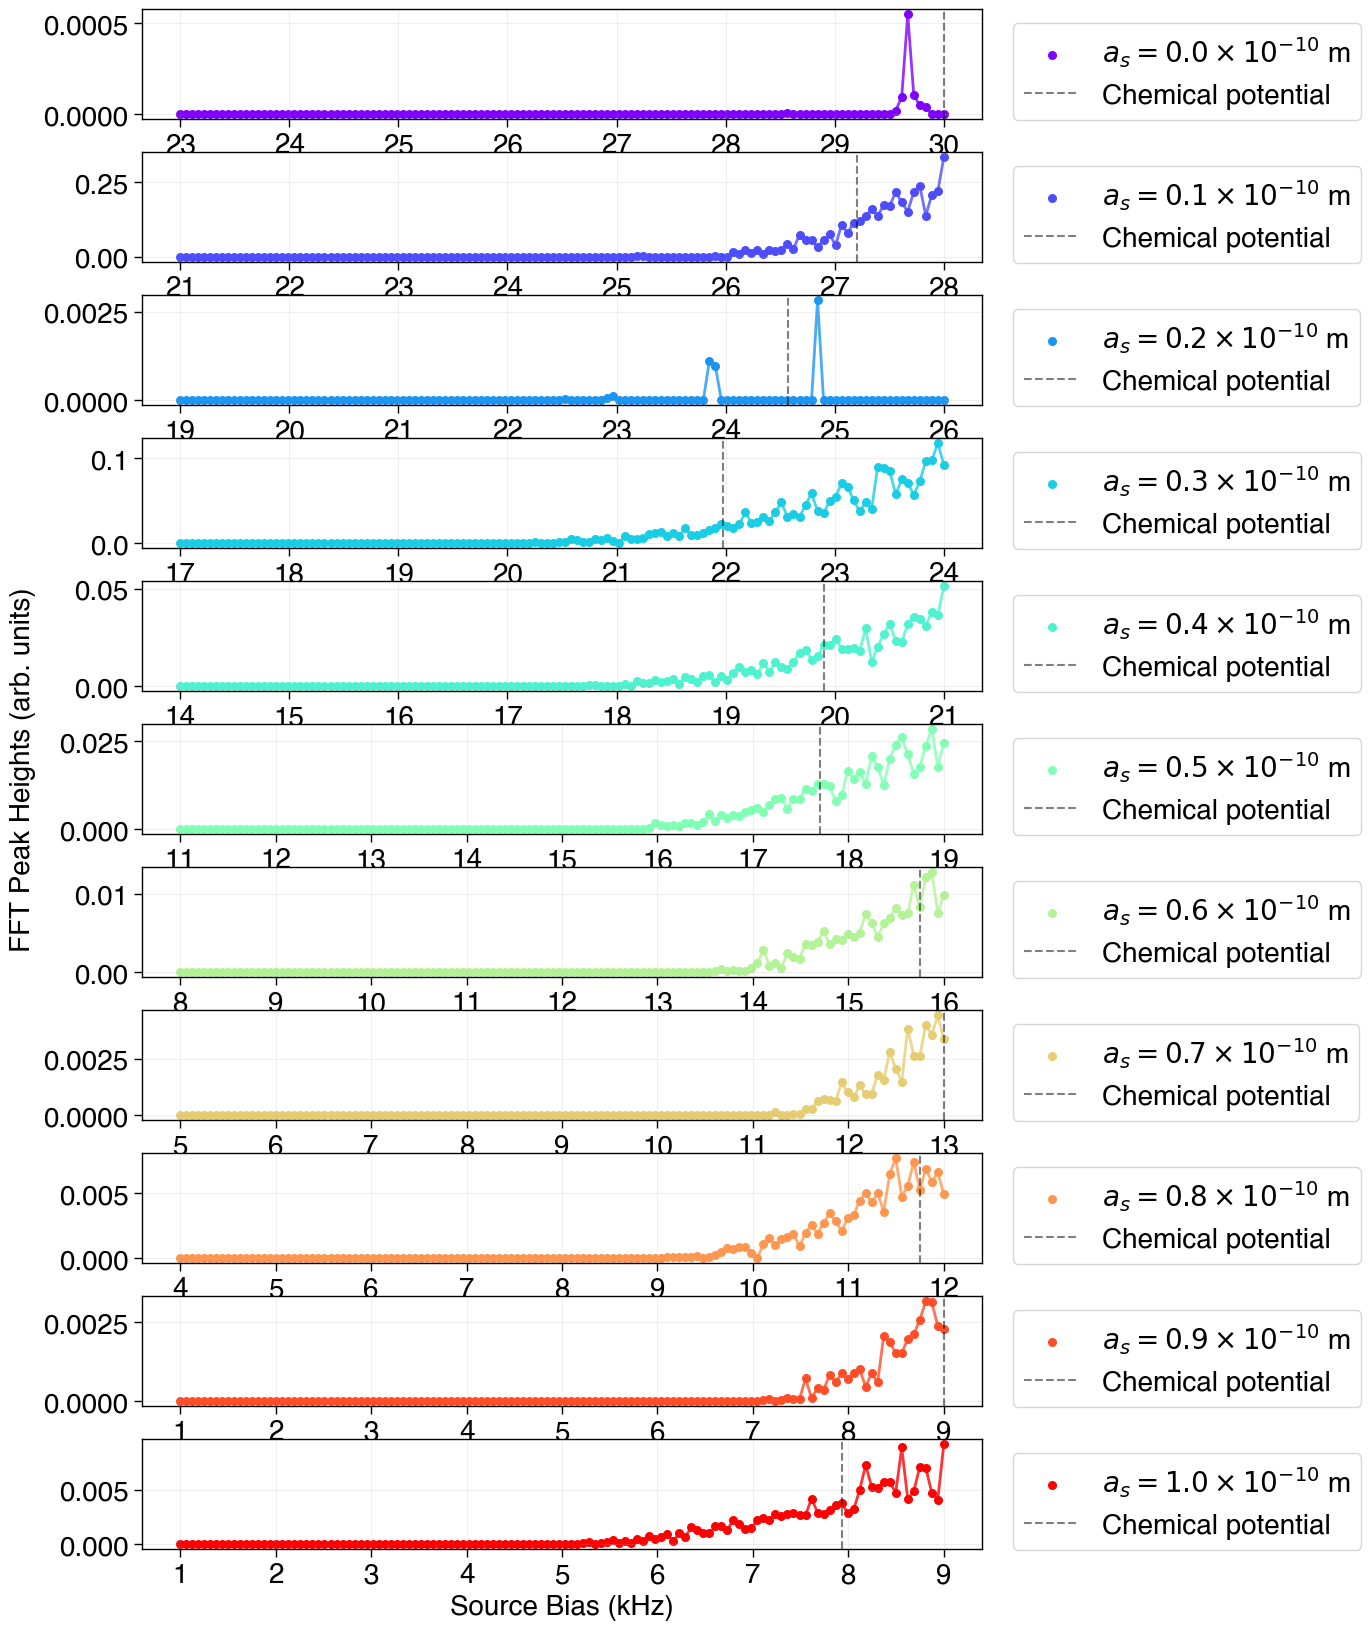

In [79]:
fig = plt.figure(figsize=(12, 20))

colors = plt.cm.rainbow(np.linspace(0, 1, len(drain_peak_height_lst)))

# Add a common y-axis label
fig.text(0.04, 0.5, 'FFT Peak Heights (arb. units)', va='center', rotation='vertical', size=med)

# Plot all a_s values
for i, (peaks, a_s, color, source_bias, chemical_potential_V_SS_value) in enumerate(zip(
     drain_peak_height_lst, 
     a_s_lst, 
     colors, 
     source_bias_lst,
     chemical_potential_V_SS_value_lst
), 1):
     ax = plt.subplot(len(drain_peak_height_lst), 1, i)
     
     # Create scatter plot with dotted lines
     plt.plot(source_bias, peaks, linestyle='-', color=color, alpha=0.8, linewidth=2)
     plt.scatter(source_bias, peaks, color=color, s=30, marker='o',
               label=f'$a_s = {a_s:.1f} \\times 10^{{-10}}$ m')
     
     # Add vertical lines for chemical potentials
     plt.axvline(x=chemical_potential_V_SS_value, color='k', linestyle='--', alpha=0.5, 
                label='Chemical potential')
     
     # Place legend outside the plot with smaller font
     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=small)
     
     # Set y-axis limit and grid
     #plt.ylim(0, 5000)
     plt.grid(True, alpha=0.2)
     
     # Format ticks and spines
     ax.tick_params(direction='out', length=6, width=1)
     for spine in ax.spines.values():
         spine.set_linewidth(1)
     
     # Only show x-axis label on the bottom subplot
     if i == len(drain_peak_height_lst):
         plt.xlabel('Source Bias (kHz)', fontsize=med)
     else:
         plt.xlabel('')

# Adjust layout
plt.subplots_adjust(left=0.15, right=0.85, hspace=0.3)
plt.show()

In [80]:
max_heights_values_lst = []
b_indices_of_max = []

for heights, sb, cp in zip(drain_peak_height_lst, source_bias_lst, chemical_potential_V_SS_value_lst):
    mask = sb < cp
    if np.any(mask):  # check if any value is below chemical potential
        heights_below_chem = heights[mask]
        max_height_val = np.max(heights_below_chem)
        max_heights_values_lst.append(max_height_val)

        # Get b index corresponding to the max height
        b_indices = np.where(mask)[0]
        b_index_of_max = b_indices[np.argmax(heights_below_chem)]
        b_indices_of_max.append(b_index_of_max)
    else:
        max_heights_values_lst.append(0)
        b_indices_of_max.append(None)

In [81]:
# Corresponding $V_{SS}$ values
source_bias_max_values = [source_bias_lst[i][b_indices_of_max[i]] if b_indices_of_max[i] is not None else None for i in range(len(b_indices_of_max))]

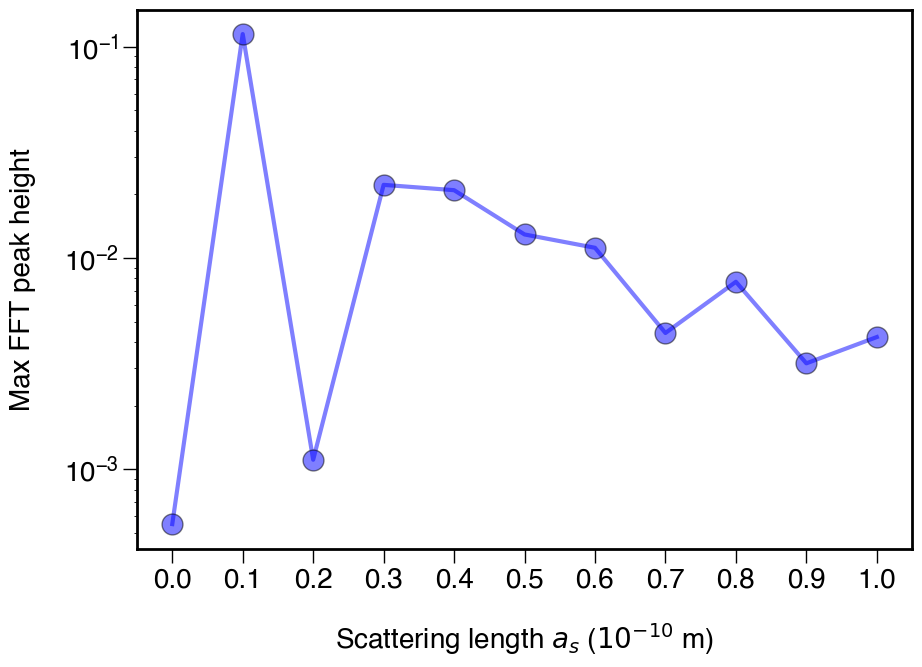

In [82]:
# matplotlib parameters 
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)     

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(a_s_lst, np.array(max_heights_values_lst), 'o-', linewidth=3, markersize=15, color='blue', alpha=0.5, markeredgecolor='black')
plt.xlabel(r'Scattering length $a_s$ ($10^{-10}$ m)', labelpad=20)
plt.ylabel(r'Max FFT peak height', labelpad=20)
ax.tick_params(axis='x', direction='out', length=10, width=1, color='k')
ax.tick_params(axis='y', direction='out', length=10, width=1, color='k')
plt.xticks(np.around(a_s_lst,1))
for spine in ax.spines.values():
     spine.set_linewidth(2)
# path = '/Users/sasankadowarah/atomtronics/after_APS_figures/resolution_15_time_6/peak_FFT_heights/'
# os.chdir(path)
# plt.savefig('max_height_vs_a_s_normalized_1.pdf', dpi=600, bbox_inches='tight')
plt.yscale('log')
plt.show()

# Atom numbers at the maximum FFT peak

In [83]:
# dt = 1.e-6
# time_lst = np.arange(0, 300*1.e-3, dt)

# tfinal = 300*1.e-3
# index_closest = np.argmin(np.abs(time_lst - tfinal))

# source_well_final_atom_number_lst = []
# gate_well_final_atom_number_lst = []
# drain_well_final_atom_number_lst = []


# i = 0
# for folder_name in folder_name_lst:
#     max_b_index = b_indices_of_max[i]
#     print("Folder name: ", folder_name)
#     print("b_index: ", b_index)
#     path = f'/Volumes/SASANKA_SSD/atomtronics_backup/After_APS_Meeting_data_new/adjusted_V_SS/{folder_name}/b{max_b_index}'
#     os.chdir(path)
#     source_atom_number = np.load("source_well_atom_number_arr.npy")
#     gate_atom_number = np.load("gate_well_atom_number_arr.npy")
#     drain_atom_number = np.load("drain_well_atom_number_arr.npy")

#     source_well_final_atom_number_lst.append(source_atom_number[index_closest])
#     gate_well_final_atom_number_lst.append(gate_atom_number[index_closest])
#     drain_well_final_atom_number_lst.append(drain_atom_number[index_closest])      

In [84]:
# # Plot the final atom numbers
# fig, ax = plt.subplots(figsize=(10, 7))
# #plt.plot(a_s_SI, source_well_final_atom_number_lst, 'o-', linewidth=3, markersize=15, color='blue', alpha=0.5, markeredgecolor='black', label='Source well')
# plt.plot(a_s_SI, gate_well_final_atom_number_lst, 'o-', linewidth=3, markersize=15, color='red', alpha=0.5, markeredgecolor='black', label='Gate well')
# plt.plot(a_s_SI, drain_well_final_atom_number_lst, 'o-', linewidth=3, markersize=15, color='green', alpha=0.5, markeredgecolor='black', label='Drain well')
# plt.xlabel(r'Scattering length $a_s$ ($10^{-10}$ m)', labelpad=20)
# plt.ylabel(r'Final atom number', labelpad=20)
# ax.tick_params(axis='x', direction='out', length=10, width=1, color='k')
# ax.tick_params(axis='y', direction='out', length=10, width=1, color='k')
# #plt.xticks(a_s_lst)
# for spine in ax.spines.values():
#      spine.set_linewidth(2)
# plt.legend(loc='upper right', fontsize=med)
# # path = '/Users/sasankadowarah/atomtronics/after_APS_figures/resolution_15_time_6/peak_FFT_heights/'
# # os.chdir(path)
# # plt.savefig('final_atom_number_vs_a_s_normalized.pdf', dpi=600, bbox_inches='tight')
# # plt.yscale('log')
# plt.show()

In [85]:
# fig, ax1 = plt.subplots(figsize=(10, 7))

# # First y-axis - Max FFT peak heights
# color1 = 'blue'
# ax1.plot(a_s_SI, np.array(max_heights_values_lst) / 1.e7, 'o-', linewidth=3, 
#            markersize=15, color=color1, alpha=0.5, markeredgecolor='black',
#            label='Max FFT peak height')
# ax1.set_xlabel(r'Scattering length $a_s$ ($10^{-10}$ m)', labelpad=20)
# ax1.set_ylabel(r'Max FFT peak height $\times 10^{7}$', color=color1, labelpad=20)
# ax1.tick_params(axis='y', labelcolor=color1)

# # Second y-axis - Drain well final atom numbers
# ax2 = ax1.twinx()
# color2 = 'red'
# ax2.plot(a_s_SI, np.array(drain_well_final_atom_number_lst)/1.e3, 's-', linewidth=3, 
#            markersize=15, color=color2, alpha=0.5, markeredgecolor='black',
#            label='Total drain atom number')
# ax2.set_ylabel(r'Total drain atom number $\times 10^{3}$', color=color2, labelpad=20)
# ax2.tick_params(axis='y', labelcolor=color2)

# # Formatting
# ax1.tick_params(axis='x', direction='out', length=10, width=1, color='k')
# for spine in ax1.spines.values():
#      spine.set_linewidth(2)

# # Add legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=med)

# plt.tight_layout()

# # path = '/Users/sasankadowarah/atomtronics/after_APS_figures/resolution_15_time_6/peak_FFT_heights/'
# # os.chdir(path)
# # plt.savefig('max_height_and_drain_atom_number_vs_a_s_normalized.pdf', dpi=600, bbox_inches='tight')
# plt.show()